In [54]:
import msprime
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import SVG
matplotlib.rcParams['figure.figsize'] = (8,5)

# Features

In [29]:
ts = msprime.sim_ancestry(
    samples=500, 
    sequence_length=1e7, 
    population_size=4000)
ts

In [30]:
recomb_map = msprime.RateMap(
    position=[0, 5e6, 10e6],
    rate=[1e-8, 1e-9])
ts = msprime.sim_ancestry(
    samples=500,
    population_size=4000,
    recombination_rate=recomb_map,
)
ts

In [31]:
recomb_map = msprime.RateMap(
    position=[0, 5e6, 10e6],
    rate=[1e-8, 1e-9])
ts = msprime.sim_ancestry(
    samples=1000,
    population_size=4000,
    recombination_rate=recomb_map,
    gene_conversion_rate=1e-7,
    gene_conversion_tract_length=100,
)
ts

In [32]:
demog = msprime.Demography()
demog.add_population(name='A', initial_size=2000)
demog.add_population(name='B', initial_size=2000)
demog.set_symmetric_migration_rate(
    populations=['A', 'B'],
    rate=1e-4)

recomb_map = msprime.RateMap(position=[0, 5e6, 10e6], rate=[1e-8, 1e-9])
ts = msprime.sim_ancestry(
    samples={'A': 250, 'B': 250},
    demography=demog,
    recombination_rate=recomb_map,
    gene_conversion_rate=1e-7,
    gene_conversion_tract_length=100,
)
ts

In [33]:
demog = msprime.Demography()
demog.add_population(name='A', initial_size=2000)
demog.add_population(name='B', initial_size=2000)
demog.set_symmetric_migration_rate(populations=['A', 'B'], rate=1e-4)
recomb_map = msprime.RateMap(position=[0, 5e6, 10e6], rate=[1e-8, 1e-9])
ts = msprime.sim_ancestry(
    samples={'A': 250, 'B': 250},
    demography=demog,
    recombination_rate=recomb_map,
    gene_conversion_rate=1e-7,
    gene_conversion_tract_length=100,
)
# add mutations
mut = msprime.F84(kappa=1.5)
mut_map = msprime.RateMap(
    position=[0, 5e6, 10e6],
    rate=[1e-9, 1e-8])
mts = msprime.sim_mutations(ts, model=mut, rate=mut_map)
mts

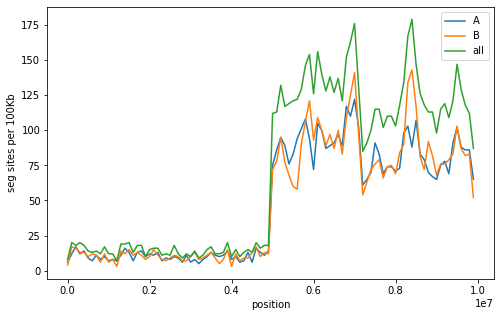

In [55]:
windows = np.linspace(0, mts.sequence_length, 101)
segsites = mts.segregating_sites(
    sample_sets=[mts.samples(0), mts.samples(1), mts.samples()],
    windows=windows, span_normalise=False
)

plt.plot(windows[:-1], segsites, label=['A', 'B', 'all'])
plt.xlabel('position')
plt.ylabel('seg sites per 100Kb')
plt.legend();

# Mutations

## nucleotides

In [60]:
import msprime
import numpy as np
import tskit

dem = msprime.Demography.from_species_tree("((A:900,B:900)ab:100,C:1000)abc;", initial_size=1e3)
samples = {"A": 20, "B": 20, "C":20}  # take 20 diploids from terminal populations A, B, C
ts_full = msprime.sim_ancestry(
   samples, demography=dem, sequence_length=5e4, recombination_rate=1e-8, random_seed=1234
)
first_4_nodes = [0, 1, 2, 3]  # ids of the first 4 sample nodes (here, 2 individuals from A)
eight_nodes = first_4_nodes + [40, 41, 80, 81]  # Add nodes from individuals in B & C
ts_tiny = ts_full.simplify(first_4_nodes)  # a tiny 4-tip TS
ts_small = ts_full.simplify(eight_nodes)   # a small 8-tip TS


In [104]:
ts_mutated = msprime.sim_mutations(ts_small, rate=1e-7, random_seed=7)

7 [3602.0]


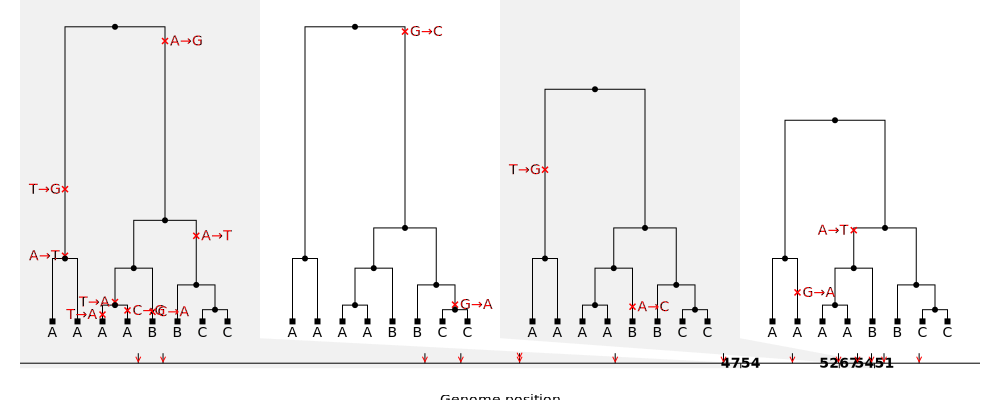

In [124]:
x_limits = [1000, 6000]

nd_labels = {}  # An array of labels for the nodes
for n in ts_mutated.nodes():
    # Set sample node labels from metadata. Here we use the population name, but you might want
    # to use the *individual* name instead, if the individuals in your tree sequence have names
    if n.is_sample():
        nd_labels[n.id] = ts_mutated.population(n.population).metadata["name"]

mut_labels = {}  # An array of labels for the mutations
for mut in ts_mutated.mutations():  # Make pretty labels showing the change in state
    site = ts_mutated.site(mut.site)
    older_mut = mut.parent >= 0  # is there an older mutation at the same position?
    prev = ts_mutated.mutation(mut.parent).derived_state if older_mut else site.ancestral_state
    mut_labels[mut.id] = "{}→{}".format(prev, mut.derived_state)

SVG(ts_mutated.draw_svg(
        x_lim=x_limits,
        node_labels=nd_labels,
        mutation_labels=mut_labels,
        size=(1000,400),
        path="../figs/mutated_trees.svg",
    ))


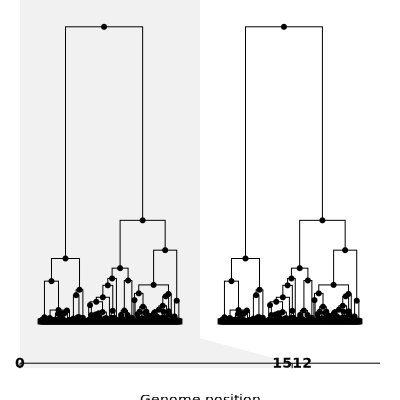

In [211]:
SVG(ts_full.draw_svg(
    x_lim=[0, 2000],
    node_labels={},
    size=(400, 400),
    path="../figs/plain_ts.svg"
))

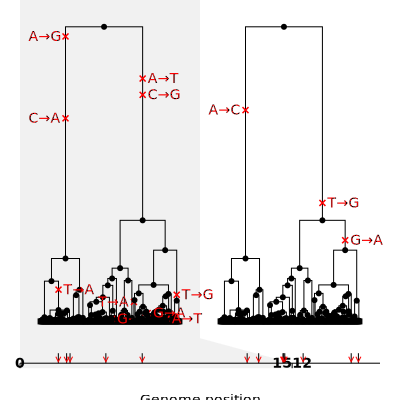

In [212]:
mts = msprime.sim_mutations(ts_full, rate=1e-7, random_seed=123)

mut_labels = {}  # An array of labels for the mutations
for mut in ts_mutated.mutations():  # Make pretty labels showing the change in state
    site = ts_mutated.site(mut.site)
    older_mut = mut.parent >= 0  # is there an older mutation at the same position?
    prev = ts_mutated.mutation(mut.parent).derived_state if older_mut else site.ancestral_state
    mut_labels[mut.id] = "{}→{}".format(prev, mut.derived_state)
SVG(mts.draw_svg(
    x_lim=[0, 2000],
    node_labels={},
    mutation_labels=mut_labels,
    size=(400, 400),
    path="../figs/mutated_ts.svg"
))

## a mutation matrix model

In [208]:
alleles = ["💩", "🎄", "🔥"]
model = msprime.MatrixMutationModel(
    alleles,
    root_distribution = [0.0, 1.0, 0.0],
    transition_matrix = [[0.0, 1.0, 0.0],
                         [0.0, 0.2, 0.8],
                         [1.0, 0.0, 0.0]]
)
ts = msprime.sim_ancestry(5, population_size=1e4, recombination_rate=1e-8, sequence_length=1000, random_seed=9)
mts = msprime.sim_mutations(ts, rate=5e-8, model=model, random_seed=1)

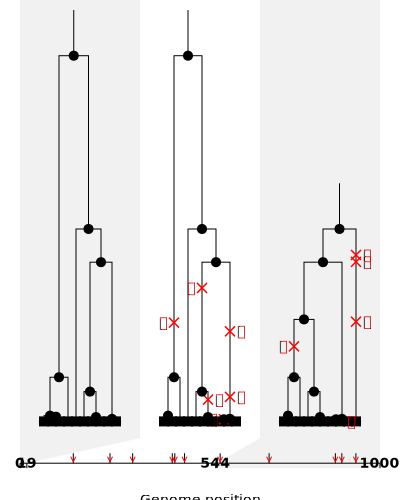

In [210]:
SVG(mts.draw_svg(
        size=(400,500),
        node_labels={},
        mutation_labels={m.id: m.derived_state for m in mts.mutations()},
        symbol_size=10,
        force_root_branch=True,
        path="../figs/fire_trees.svg",
    ))

# Sweeps

In [56]:
sweep_model = msprime.SweepGenicSelection(position=2.5e4,
    s=0.01, start_frequency=0.5e-4, end_frequency=0.99, dt=1e-6)
sts = msprime.sim_ancestry(9,
    model=[sweep_model, msprime.StandardCoalescent()],
    population_size=1e4,
    recombination_rate=1e-8,
    sequence_length=5e4, random_seed=9,
)


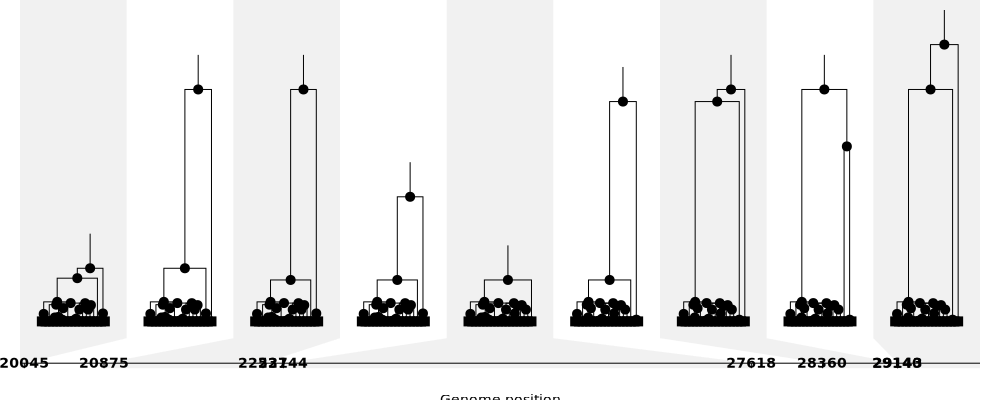

In [57]:
def sel_svg(**kwargs):
    return sts.draw_svg(
        size=(1000,400),
        x_lim=[2e4, 3e4],
        node_labels={},
        symbol_size=10,
        force_root_branch=True,
        **kwargs
    )
    
SVG(sel_svg())

In [58]:
sel_svg(path="../figs/sweep_trees.svg");

In [13]:
help(sts.draw_svg)

Help on method draw_svg in module tskit.trees:

draw_svg(path=None, *, size=None, x_scale=None, time_scale=None, tree_height_scale=None, node_labels=None, mutation_labels=None, root_svg_attributes=None, style=None, order=None, force_root_branch=None, symbol_size=None, x_axis=None, x_label=None, x_lim=None, y_axis=None, y_label=None, y_ticks=None, y_gridlines=None, **kwargs) method of tskit.trees.TreeSequence instance
    Return an SVG representation of a tree sequence.
    
    When working in a Jupyter notebook, use the ``IPython.display.SVG`` function
    to display the SVG output from this function inline in the notebook::
    
        >>> SVG(tree.draw_svg())
    
    The visual elements in the svg are
    `grouped <https://www.w3.org/TR/SVG2/struct.html#Groups>`_
    for easy styling and manipulation. The entire visualization with trees and X
    axis is contained within a group of class ``tree-sequence``. Each tree in
    the displayed tree sequence is contained in a group of cla

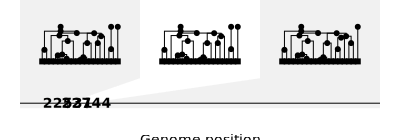

In [225]:
ots = msprime.sim_ancestry(9,
    model=sweep_model,
    population_size=1e4,
    recombination_rate=1e-8,
    sequence_length=5e4, random_seed=9,
)
SVG(ots.draw_svg(
    x_lim=[2.2e4, 2.6e4],
    size=(400,140),
    node_labels={},
    path="../figs/pre_recap.svg"
))

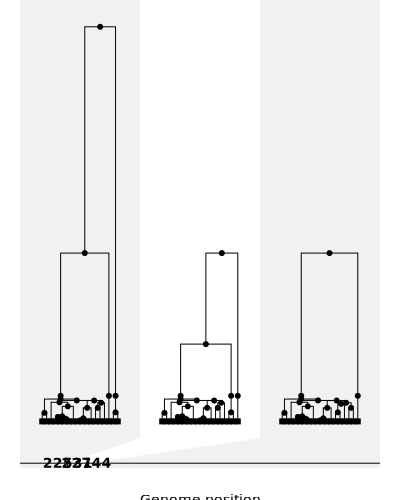

In [224]:
rts = msprime.sim_ancestry(
    initial_state=ots,
    recombination_rate=1e-8,
    population_size=1e4,
    random_seed=10
)
SVG(rts.draw_svg(
    x_lim=[2.2e4, 2.6e4],
    size=(400,500),
    node_labels={},
    path="../figs/post_recap.svg"
))

# SLiM

In [200]:
slim_recipe = '''
initialize() {
   initializeTreeSeq();
   initializeMutationRate(1e-7);
   initializeMutationType("m1", 0.5, "f", 0.0);
   initializeGenomicElementType("g1", m1, 1.0);
   initializeGenomicElement(g1, 0, 1200000);
   initializeRecombinationRate(1e-8);
}
1 { sim.addSubpop("p1", 4); }
1: { sim.treeSeqRememberIndividuals(p1.individuals); }
12 late() { sim.treeSeqOutput("slim.trees"); }
'''
with open("small.slim", "w") as f:
    f.writelines(slim_recipe)

In [201]:
%%bash
slim -s 23 small.slim

// Initial random seed:
23

// RunInitializeCallbacks():
initializeTreeSeq();
initializeMutationRate(1e-07);
initializeMutationType(1, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 1200000);
initializeRecombinationRate(1e-08);

// Starting run at generation <start>:
1 



#WARNING (SLiMSim::RunInitializeCallbacks): with tree-sequence recording enabled and a non-zero mutation rate, a neutral mutation type was defined and used; this is legal, but usually undesirable, since neutral mutations can be overlaid later using the tree-sequence information.


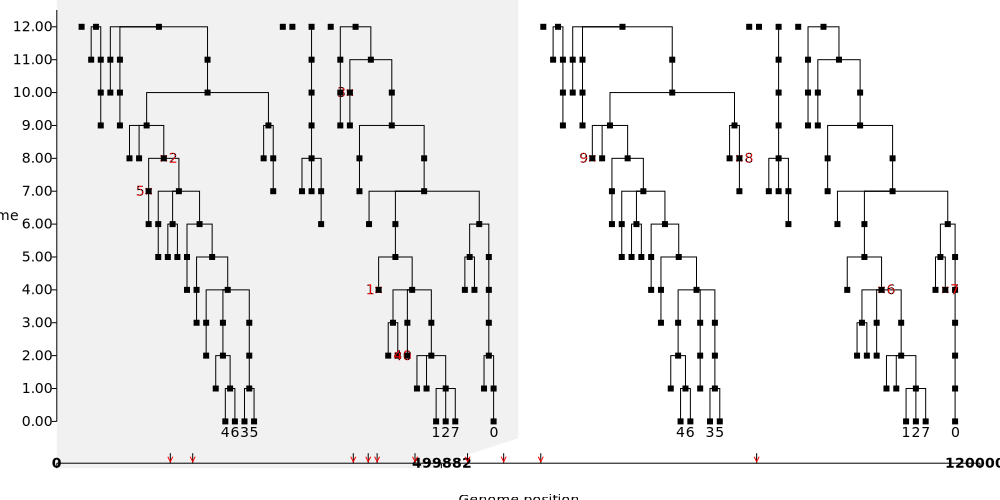

In [204]:
slim_ts = tskit.load("slim.trees")
node_labels = {}
k = 0
for n in slim_ts.nodes():
    if n.time == 0.0:
        node_labels[n.id] = k
        k += 1
SVG(slim_ts.draw_svg(
    size=(1000, 500),
    node_labels=node_labels,
    y_axis=True,
))

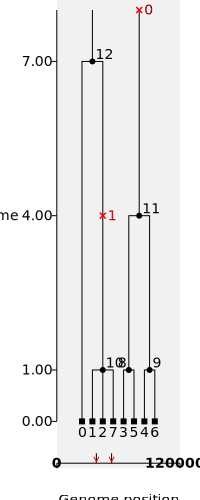

In [205]:
SVG(slim_ts.simplify(list(node_labels.keys())).draw_svg(
    size=(200, 500),
    y_axis=True,
))

In [193]:
node_labels.keys()

dict_keys([96, 97, 98, 99, 100, 101, 102, 103])